BikeShareholders e0415714 e0540272 e0544587 e0418087 e0564529

In [1]:
#to match version on colab with that of our PC's
!pip install statsmodels==0.12.2
import pandas as pd
import numpy as np
from datetime import datetime
import os
import warnings
import time
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

# Set plot parameters
plt.rcParams['figure.figsize'] = 18, 8
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 1

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
#load dataset
bike_df = pd.read_csv("Bike_Sharing(extra).csv", index_col=0)
bike_df = bike_df.iloc[:, 0:20]

#dataset preview
bike_df.head(5)

,index,Time,Date,Date2,season,yr,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,total
S_No,,,,,,,,,,,,,,,,,,,,
1,1.0,01/01/2011 00:00,01/01/2011,1,1,0,1,1,0,0,6,0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
2,2.0,01/01/2011 01:00,01/01/2011,1,1,0,1,1,1,0,6,0,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
3,3.0,01/01/2011 02:00,01/01/2011,1,1,0,1,1,2,0,6,0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
4,4.0,01/01/2011 03:00,01/01/2011,1,1,0,1,1,3,0,6,0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
5,5.0,01/01/2011 04:00,01/01/2011,1,1,0,1,1,4,0,6,0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


<h3>1. Basic Data Cleaning</h3>

It is observed that there are 165 rows with missing values in certain columns. These data are not missing at random - all affected columns with missing values are in the following columns: 

<li>Date</li>
<li>weathersit</li>
<li>temp</li>
<li>atemp</li>
<li>hum</li>
<li>windspeed</li>
<li>casual</li>
<li>registered</li>
<li>total</li>

As we were exploring the dataset, we also noticed that if we were to take out the missing rows, the minimum number of total users at any time on any day is 1 (~120 entries). Logically speaking, over the two year period, there should be at least a few instances whereby nobody in the city is using CityBikes bike. This leads us to believe that the missing rows (also ~120 entries) are instances whereby nobody is using the bikes and since nobody is using the bikes, no data was recorded. As such, we filled these missing user counts with 0.

Since the "Time" column is fully intact, we can convert the Time column to datetime objects and then extract the Date data to fill up the missing "Date" cells.

As for the climate-related data, we can reasonably estimate the values of the missing cells by taking 3-hour moving average, except for the column "weathersit". For the column "weathersit", we fill the missing cells with the the weathersit of the preceding hour. This is because a moving average would not make sense since the weather condition from hours ago are likely to be irrelevant in predicting the weather in the next hour. Since weather can change very quickly, the only reasonable way to predict these missing cells is by referencing the weather condition from the earliest point of reference, which is an hour ago.

In [3]:
#check if there are any rows with any missing value (result shows that all rows have complete data for each column)
bike_df.loc[bike_df.isna().any(axis=1)]

,index,Time,Date,Date2,season,yr,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,total
S_No,,,,,,,,,,,,,,,,,,,,
30,NaN,02/01/2011 05:00,NaN,2,1,0,1,2,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,NaN,03/01/2011 02:00,NaN,3,1,0,1,3,2,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,NaN,03/01/2011 03:00,NaN,3,1,0,1,3,3,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,04/01/2011 03:00,NaN,4,1,0,1,4,3,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,05/01/2011 03:00,NaN,5,1,0,1,5,3,0,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16045,NaN,30/10/2012 12:00,NaN,669,4,1,10,30,12,0,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16252,NaN,08/11/2012 03:00,NaN,678,4,1,11,8,3,0,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16756,NaN,29/11/2012 03:00,NaN,699,4,1,11,29,3,0,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#converts time and date column to datetime object, keeping only date information for data in "Date" column
bike_df['Time'] = pd.to_datetime(bike_df['Time'], format = '%d/%m/%Y %H:%M')
bike_df['Date'] = pd.to_datetime(bike_df['Date'], format = '%d/%m/%Y').dt.date
#get index of columns with missing values
na_index = bike_df.loc[bike_df.isna().any(axis=1)].index.tolist()

#dictionary of missing columns which we will deal with using 3 hour running average, as well as their corresponding decimal places for rounding
running_avg_col = {"temp":2, "atemp":4, "hum":2, "windspeed":4}

for i in na_index:
    #extract date from "time" column to fill in the blanks in the "date" column
    bike_df.loc[i, "Date"] = datetime.date(bike_df.loc[i, "Time"])
    print(f"missing date at index {i} replaced with {datetime.date(bike_df.loc[i, 'Time'])}")
    
    #filling in missing weather information
    bike_df.loc[i, "weathersit"] = bike_df.loc[i-1, "weathersit"]
    print(f"missing weathersit at index {i} replaced with {bike_df.loc[i-1, 'weathersit']}")
    
    #filling in missing temp, atemp, hum, windspeed, casual, registered information
    for c in running_avg_col:
        running_avg = round(bike_df.loc[i-3:i, c].mean(), running_avg_col[c])
        bike_df.loc[i, c] = running_avg
        print(f"avg for: {c} at index {i} is {running_avg}")
    
    #filling in missing "total" value by summing up values in the "casual" and "registered" cells of each affected row
    bike_df.loc[i, "total"] = bike_df.loc[i, ["casual", "registered"]].sum(axis=0)
    print(f"total users at index {i} calculated to be {bike_df.loc[i, ['casual', 'registered']].sum(axis=0)}")
    
#only keep time data in 'time' column and date date in 'date' column
bike_df['Time'] = bike_df['Time'].dt.time

#fill casual, registered and total number of riders as 0
bike_df.loc[na_index, ['casual', 'registered', 'total']] = 0

#drop index column since it is redundant
bike_df = bike_df.drop("index", axis = 1)

missing date at index 30 replaced with 2011-01-02
missing weathersit at index 30 replaced with 2.0
avg for: temp at index 30 is 0.45
avg for: atemp at index 30 is 0.4444
avg for: hum at index 30 is 0.96
avg for: windspeed at index 30 is 0.2239
total users at index 30 calculated to be 0
missing date at index 51 replaced with 2011-01-03
missing weathersit at index 51 replaced with 1.0
avg for: temp at index 51 is 0.21
avg for: atemp at index 51 is 0.197
avg for: hum at index 51 is 0.45
avg for: windspeed at index 51 is 0.3134
total users at index 51 calculated to be 0
missing date at index 52 replaced with 2011-01-03
missing weathersit at index 52 replaced with 1.0
avg for: temp at index 52 is 0.21
avg for: atemp at index 52 is 0.1869
avg for: hum at index 52 is 0.44
avg for: windspeed at index 52 is 0.3632
total users at index 52 calculated to be 0
missing date at index 76 replaced with 2011-01-04
missing weathersit at index 76 replaced with 1.0
avg for: temp at index 76 is 0.15
avg for

In [5]:
#check again for missing values
print(f"number of rows with missing values: {len(bike_df.loc[bike_df.isna().any(axis=1)])}")

number of rows with missing values: 0


<h3>2. Outlier Detection</h3>

In this section, we detected outliers using isolation forest, local outlier factor and elliptical envelope. The subset of all outliers detected using the three methods are then taken as the outliers for the dataset. With the index of these outlying rows, we constructed another column called 'is_outlier', which labels each row based on their status - True for outliers and False for otherwise.

In [6]:
st0 = time.time()
stm = st0
var_ls = bike_df.columns.tolist()
[var_ls.remove(each) for each in ['Time', 'Date', 'Date2', 'season', 
                                  'yr', 'mnth', 'day', 
                                  'hr', 'holiday', 'weekday', 
                                  'workingday', 'weathersit']]
d = bike_df.loc[:, var_ls]
r = len(bike_df.index)
rs = 1

#Isolation Forest
from sklearn.ensemble import IsolationForest
#-1 in 'g' identifies an outlier position:

g = IsolationForest(n_jobs=-1, random_state=rs if rs==None else rs*2).fit_predict(d).tolist()
print('\nNumber of IsolationForest outliers:', g.count(-1))
print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

#Local Outlier Factor
from sklearn.neighbors import LocalOutlierFactor
a0 = LocalOutlierFactor(n_jobs=-1)
#-1 in 'a' identifies an outlier position:
a = a0.fit_predict(d).tolist()
ac = a.count(-1) #keep for EllipticEnvelope
an = a0.negative_outlier_factor_ #use this size info to rank outliers later
print('\nNumber of LocalOutlierFactor outliers:', ac)
print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

#Elliptic Envelope for Gaussian distribution
from sklearn.covariance import EllipticEnvelope
#-1 in 'e' identifies an outlier position:
e = EllipticEnvelope(contamination=min(0.1, ac/r), random_state=rs if rs==None else rs*3).fit_predict(d).tolist()
print('\nNumber of EllipticEnvelope outliers:', e.count(-1))
print('... took', '%.2f' % ((time.time() - stm) / 60), 'mins.')
stm = time.time()

#find shared outliers
if 'b' in vars():
    f = [-1 if s==-1 and t==-1 and u==-1 and v==-1 else 1 for s, t, u, v in zip(a, b, g, e)]
    del b
else:
    f = [-1 if s==-1 and t==-1 and u==-1 else 1 for s, t, u in zip(a, g, e)]
p = f.count(-1)

if p > 0:
    q = [i for i, z in enumerate(f) if z == -1] #indices of outliers
    q = [z for _, z in sorted(zip(an[q], q))][:100] #indices of sorted worst outliers
    print('\nNumber of outliers common to all lists:', p,
          '\nIndices of up to 100 sorted outliers with the worst first:', q,
          'from [0 to', str(r - 1) + '].')
    print('\nProportion of data outlying:', '%.5f' % (p / r))
else:
    print('\nNo outlier common to all lists.')
print('\nOutliers detection took', '%.2f' % ((time.time() - st0) / 60), 'mins.')

#adding a new column to identify if a row is outlying
bike_df['is_outlier'] = False
bike_df.iloc[q, 19] = True


Number of IsolationForest outliers: 3513
... took 0.02 mins.

Number of LocalOutlierFactor outliers: 215
... took 0.00 mins.

Number of EllipticEnvelope outliers: 215
... took 0.04 mins.

Number of outliers common to all lists: 6 
Indices of up to 100 sorted outliers with the worst first: [2222, 11101, 12112, 11103, 11104, 14968] from [0 to 17543].

Proportion of data outlying: 0.00034

Outliers detection took 0.07 mins.


<h3>3. Multi-collinearity Elimination with Variance Inflation Factor Threshold</h3>

In this section, the multi-collinearity issue is taken care of using the VIF (Variance Inflation Factor) method. The following function will go through a given list of numeric variables and check if the VIF is greater than 10. If it is greater than 10, the variale with the highest VIF is dropped. The output is a list of numeric variables with VIF within the threshold of 10.

In [7]:
def collinearity_filter(v, df):
    var_ls = v
    curr_vif = np.inf
    
    while curr_vif > 10:
        df2 = df.loc[:, var_ls]
        result = pd.DataFrame({'vif': [variance_inflation_factor(df2.values, i) for i in range(0, len(df2.columns))]}, index = df2.columns).sort_values(by = 'vif', ascending = True)
        curr_vif = result['vif'][-1]
        var_ls.remove(result.index[-1])
            
    return(var_ls)

<h3>4. Variable Transformation</h3>

To save time, the following function is used to perform variable transformation. The required parameters  are:
    <ol>
    <li> List of numeric variable column names </li>
    <li> Dataframe</li>
    </ol>
    
The function outputs a list of variable names (transformed variables and their untransformed forms).

In [8]:
def transform_var(num_var, df):
    ls = []
    for each in num_var:
        if sum(df[each] < 0) == 0:
            ls.append(each)
            ls.append(f'np.power({each}, 2)')
            ls.append(f'np.power({each}, 0.5)')
        else:
            ls.append(each)
            ls.append(f'np.power({each}, 3)')
            ls.append(f'np.power({each}, 1/3)')
    return(ls)

<h3>5. First Model - Multiple Regression to Predict Number of Users</h3>

Here, multi-regression models are constructed to explore the relationship between the various features and the number of casual and registered users at any given hour of a day.

In [9]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

<h3>5.1. MLR Variable Selection Round 1</h3>

The following chunk consists of code for round 1 of variable selection. We first segregated the categorical variables and numeric variables and ran the collinearity and variable transformation functions on the list of numeric variables. After which, the numeric variables should only consist of variables with no correlation (or rather, weak correlation) to each other, as well as transformed variants of themselves. We then combined the categorical variables and numeric variables together into a pool of variables to be used for variable selection (all_var).

In [10]:
#this section controls the list of features used in the models
formula = 'total ~'

#'time' and 'date' not included as their values are already reflected in the 'hour' and 'day', 'month', year' columns
cat_var = ['season', 'mnth', 'day', 'hr', 
           'holiday', 'weekday', 'workingday', 
           'weathersit', 'is_outlier']

num_var = ['temp', 'atemp', 'hum', 'windspeed']
all_var = []

for each in cat_var:
    all_var.append(f'C({each})')
    
#collinearity while excluding outliers
num_var = collinearity_filter(num_var, bike_df.loc[bike_df['is_outlier'] == False])
    
#variable transformation
num_var = transform_var(num_var, bike_df)
    
all_var = [*all_var, *num_var]

#preview variable pool before variable selection
all_var

['C(season)',
 'C(mnth)',
 'C(day)',
 'C(hr)',
 'C(holiday)',
 'C(weekday)',
 'C(workingday)',
 'C(weathersit)',
 'C(is_outlier)',
 'hum',
 'np.power(hum, 2)',
 'np.power(hum, 0.5)',
 'windspeed',
 'np.power(windspeed, 2)',
 'np.power(windspeed, 0.5)']

In [11]:
#variable selection
best_r2 = -np.inf
best_fpv = -best_r2
best_formula = ''
best_summary = ''
best_anova = ''

while len(all_var) > 1:
    #initalize formula
    formula = 'total ~'
    
    #construct formula with remaining variables in all_variables
    for each in all_var:
        if formula[-1] == '~':
            formula += f' {each}'
        else:
            formula += f' + {each}'
    model = smf.ols(formula = formula, data = bike_df).fit()
    m_r2 = model.rsquared_adj
    m_fpv = model.f_pvalue
    m_anova = sm.stats.anova_lm(model, typ=2)[0:-1].sort_values("PR(>F)", ascending = True)
    
    if m_fpv != 0 and m_fpv < best_fpv:
        best_fpv = m_fpv
        best_r2 = m_r2
        best_formula = formula
        best_summary = model.summary()
        best_anova = m_anova

    elif m_fpv == 0 and m_r2 > best_r2:
        best_fpv = m_fpv
        best_r2 = m_r2
        best_formula = formula
        best_summary = model.summary()
        best_anova = m_anova
        
    worst_feature = m_anova.index[-1]
    
    all_var.remove(worst_feature)
    
    print(f"||best adj r2: {best_r2} || model adj r2: {m_r2} | feature dropped for next set: {worst_feature}")
    
print(f'operation completed.\nbest adj r2: {best_r2} | \nbest model: {best_formula}')
print(best_anova)
print(best_summary)

||best adj r2: 0.6170360875508415 || model adj r2: 0.6170360875508415 | feature dropped for next set: np.power(windspeed, 0.5)
||best adj r2: 0.6170579132221118 || model adj r2: 0.6170579132221118 | feature dropped for next set: np.power(hum, 2)
||best adj r2: 0.6170796341758463 || model adj r2: 0.6170796341758463 | feature dropped for next set: C(holiday)
||best adj r2: 0.6170796341758463 || model adj r2: 0.6170796341758463 | feature dropped for next set: windspeed
||best adj r2: 0.6170796341758463 || model adj r2: 0.6169407750083322 | feature dropped for next set: C(day)
||best adj r2: 0.6170796341758463 || model adj r2: 0.6163974384920055 | feature dropped for next set: C(workingday)
||best adj r2: 0.6170796341758463 || model adj r2: 0.6161446677371778 | feature dropped for next set: C(weekday)
||best adj r2: 0.6170796341758463 || model adj r2: 0.6151092255497105 | feature dropped for next set: C(is_outlier)
||best adj r2: 0.6170796341758463 || model adj r2: 0.614238911443828 | feat

<h3>5.2. MLR Variables Selection Round 2 - Variable Selection</h3>

After the first round of variable selection, we now have an optimal model. With the features of this model, we then crossed them with each other with no repeats to obtain a new pool of interacted variables. Prior to variable interaction, we also filtered out the transformed variables so as to not end up in a situation whereby an untransformed variable is crossed with its transformed variant.

In [12]:
#variable interaction - extract list of features from the optimal model from variable selection round 1
best_features = best_anova.index.tolist()

#filter out transformed variables before interaction - untransformed goes into l2, transformed goes into l1
l1 = []
l2 = []
[l2.append(each) if each.find('np.power') < 0 else l1.append(each) for each in best_features]

#transformed variables removed from best_features
best_features = l2
checked = []
interact_var = []

#the untransformed best variables are crossed with each other without repeating to form the new pool of variables for selection
for each in best_features:
    if each not in checked:
            start = best_features.index(each) + 1
            for each_2 in best_features[start:]:
                interact_var.append(f'{each}*{each_2}')
                
#add back transformed variables
interact_var = [*interact_var, *l1]

#preview list of interaction variables
interact_var

['C(hr)*C(mnth)',
 'C(hr)*C(weathersit)',
 'C(hr)*C(season)',
 'C(hr)*hum',
 'C(hr)*C(workingday)',
 'C(hr)*C(is_outlier)',
 'C(hr)*C(weekday)',
 'C(hr)*C(day)',
 'C(hr)*windspeed',
 'C(hr)*C(holiday)',
 'C(mnth)*C(weathersit)',
 'C(mnth)*C(season)',
 'C(mnth)*hum',
 'C(mnth)*C(workingday)',
 'C(mnth)*C(is_outlier)',
 'C(mnth)*C(weekday)',
 'C(mnth)*C(day)',
 'C(mnth)*windspeed',
 'C(mnth)*C(holiday)',
 'C(weathersit)*C(season)',
 'C(weathersit)*hum',
 'C(weathersit)*C(workingday)',
 'C(weathersit)*C(is_outlier)',
 'C(weathersit)*C(weekday)',
 'C(weathersit)*C(day)',
 'C(weathersit)*windspeed',
 'C(weathersit)*C(holiday)',
 'C(season)*hum',
 'C(season)*C(workingday)',
 'C(season)*C(is_outlier)',
 'C(season)*C(weekday)',
 'C(season)*C(day)',
 'C(season)*windspeed',
 'C(season)*C(holiday)',
 'hum*C(workingday)',
 'hum*C(is_outlier)',
 'hum*C(weekday)',
 'hum*C(day)',
 'hum*windspeed',
 'hum*C(holiday)',
 'C(workingday)*C(is_outlier)',
 'C(workingday)*C(weekday)',
 'C(workingday)*C(day)',

These interacted variables are then put through a second round of variable selection, using a different approach to reduce the runtime. 
The thought process is as follows:
1. Four variable sare selected from the pool of interacted variables to form our initial model. 
2. We then eliminated the least significant variable out of the four, took one variable from the remaining pool and formed another model. 
3. We then compared their adjusted R-squared values to see if the new model yielded any improvements over the previous one. 
4. This process is repeated until the pool of variables is completely exhausted.

In [13]:
#variable selection round 2 - start with 4 then add and drop method
best_r2 = -np.inf
best_fpv = -best_r2
best_formula = ''
best_summary = ''
best_anova = ''

#take out 4 variables to start off with (picked from the back because those at the front have high degrees of freedom & will lead to long runtime)
initial_var = interact_var[-4:]

#drop these 4 variables from the pool of variables (interact_Var)
[interact_var.remove(each) for each in initial_var]

while len(interact_var) > 1:
    #initialize formula
    formula_2 = 'total ~'
    
    #construct formula with 4 from intial_var + 1 from interact_var
    print(f'New feature added: {interact_var[0]}')
    initial_var = [*initial_var, interact_var[0]]
    
    for each in initial_var:
        if formula_2[-1] == '~':
            formula_2 += each
        else:
            formula_2 = f'{formula_2} + {each}'
            
    #curve fitting
    model = smf.ols(formula = formula_2, data = bike_df).fit()
    
    #get statistics on model
    m_r2 = model.rsquared_adj
    m_fpv = model.f_pvalue
    m_summary = model.summary()
    m_anova = sm.stats.anova_lm(model, type = 2)[:-1].sort_values('PR(>F)', ascending = True)
    #get the worst feature (highest fstat pvalue)
    n = -1
    worst_feature = m_anova.index[n].replace(':', '*')
    while worst_feature not in interact_var:
        n -= 1
        worst_feature = m_anova.index[n].replace(':', '*')
        
    if m_fpv != 0 and m_fpv < best_fpv:
        best_r2 = m_r2
        best_fpv = m_fpv
        best_formula = formula
        best_summary = m_summary
        best_anova = m_anova
    elif m_fpv == 0 and m_r2 > best_r2:
        best_r2 = m_r2
        best_fpv = m_fpv
        best_formula = formula
        best_summary = m_summary
        best_anova = m_anova
        
    #eliminate worst feature from the list of 10 variables (9 + 1) for next round
    initial_var.remove(worst_feature)
    
    print(f'current model: \nadj r2: {m_r2} | fpval: {m_fpv} |\n')
    print('-'*100)
    print(formula_2)
    print('-'*100, '\n')
    print(f'remaining features:\n {interact_var}\n')
    print(f'worst feature dropped for next model: {worst_feature}')
    print("="*100)
    
    interact_var.remove(worst_feature)

print("|"*100)
print(best_anova)
print(best_summary)
    

New feature added: C(hr)*C(mnth)
current model: 
adj r2: 0.6339625136460061 | fpval: 0.0 |

----------------------------------------------------------------------------------------------------
total ~C(day)*C(holiday) + windspeed*C(holiday) + np.power(hum, 0.5) + np.power(windspeed, 2) + C(hr)*C(mnth)
---------------------------------------------------------------------------------------------------- 

remaining features:
 ['C(hr)*C(mnth)', 'C(hr)*C(weathersit)', 'C(hr)*C(season)', 'C(hr)*hum', 'C(hr)*C(workingday)', 'C(hr)*C(is_outlier)', 'C(hr)*C(weekday)', 'C(hr)*C(day)', 'C(hr)*windspeed', 'C(hr)*C(holiday)', 'C(mnth)*C(weathersit)', 'C(mnth)*C(season)', 'C(mnth)*hum', 'C(mnth)*C(workingday)', 'C(mnth)*C(is_outlier)', 'C(mnth)*C(weekday)', 'C(mnth)*C(day)', 'C(mnth)*windspeed', 'C(mnth)*C(holiday)', 'C(weathersit)*C(season)', 'C(weathersit)*hum', 'C(weathersit)*C(workingday)', 'C(weathersit)*C(is_outlier)', 'C(weathersit)*C(weekday)', 'C(weathersit)*C(day)', 'C(weathersit)*windspee

<h3>6. Holt-Winters' Triple Exponential Smoothing (Forecasting & Seasonality Analysis)</h3>

We are interested in investigating whether there are any seasonality or trend in the demand for shared bikes. The way we approached this is using Holt-Winters' Exponential Smoothing instead of seasonal decomposition. This is because Holt-Winters is an adaptive model which incorporates exponential smoothing for seasonality, while time series decomposition assumes that that there is a fixed seasonal pattern. 

With the seasonality and trend, it will provide us some insight on the possibility of business expansion and visualise the bike rental pattern to schedule for bike repairs and maintenance.

In [14]:
from statsmodels.tsa.api import ExponentialSmoothing

In [15]:
#aggregate total users by month - total of 24 months over 2 years
summary = bike_df.groupby(['mnth', 'yr'])['total'].sum()
summary = [*summary[::2], *summary[1::2]]

#create dataframe
bdf1 = pd.DataFrame({'mnth': [*range(0, 24)], 'total': summary})

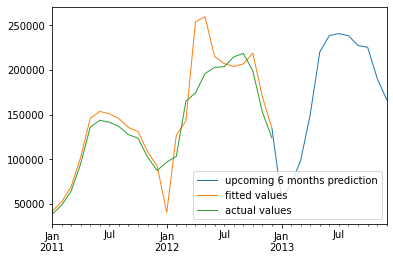

In [22]:
#prepare timestamp index to sub into aggregated data
indx = pd.date_range(datetime.strptime('2011-01-01', '%Y-%m-%d'),
              datetime.strptime('2013-01-01', '%Y-%m-%d'),
              freq='M'
             )
#subbing in timestamp index
bdf1.index = indx

#holt-winter with additive trend and multiplicative seasonality (6mo per period)
mdl = ExponentialSmoothing(bdf1['total'].astype('double'), 
                           freq = 'M', 
                           seasonal_periods = 12,
                           trend = 'add', 
                           seasonal = 'mul',
                           missing = 'raise').fit()

#predict values for next 6 months
pred_range = pd.date_range(datetime.strptime('2012-12-01', '%Y-%m-%d'),
              datetime.strptime('2014-01-01', '%Y-%m-%d'),
              freq='M'
             )
pred_val = mdl.predict(start = pred_range[0], end = pred_range[-1])

#plot predicted values, fitted values and actual values
#upcoming 6mo prediction
pred_val.plot()

#fitted values
mdl.fittedvalues.plot()

#actual values
bdf1.total.plot()
plt.legend(['upcoming 6 months prediction', 'fitted values', 'actual values'])
plt.show()

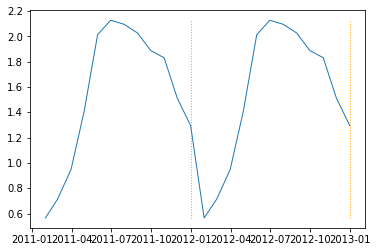

In [17]:
#visualise seasonal indices over each period, with vline separating each period
season_ind = mdl.season

plt.plot(season_ind)
for each in bdf1.index[11::12]:
    plt.vlines(each, ymin = season_ind.min(), ymax = season_ind.max(), linestyles='dotted', color = 'orange')

In [18]:
#print model summary
mdl.summary()

Dep. Variable:,total,No. Observations:,24
Model:,ExponentialSmoothing,SSE,16487416031.441
Optimized:,True,AIC,520.347
Trend:,Additive,BIC,539.196
Seasonal:,Multiplicative,AICC,657.147
Seasonal Periods:,12,Date:,"Fri, 15 Apr 2022"
Box-Cox:,False,Time:,16:37:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
smoothing_trend,0.0355357,beta,True


<h3>7. Logistics Regression</h3>

We are also interested in finding out the motivating factor behind people signing up. One way to do this is to find the relationship between instances when casual users exceed registered users. Doing so will then provide us with insight on how we can better appeal to casual cyclists to sign up.

In [19]:
import statsmodels as sm
import statsmodels.api as sma
from statsmodels.formula.api import logit

In [20]:
#add new column of binary values to indicate whether casual users is greater than registered users for each hour of each day
bike_df['casual_exceed_registered'] = bike_df['casual'] > bike_df['registered']
bike_df['casual_exceed_registered'] = bike_df['casual_exceed_registered'] * 1

#generate list of variables to select from
y = 'casual_exceed_registered'

In [21]:
#variable selection
x = [*[f'C({each})' for each in cat_var], *num_var]

best_r2 = -np.inf
best_fpv = -best_r2
best_formula = ''
best_summary = ''
best_anova_2 = ''

while len(x) > 1:
    #construct model equation
    formula = 'casual_exceed_registered ~'
    for each in x:
        if formula[-1] == '~':
            formula += f' {each}'
        else:
            formula += f' + {each}'
            
    #fitting model
    model = logit(formula = formula, data = bike_df).fit(disp = 0 , maxiter = 40)
    m_r2 = model.prsquared
    m_fpv = model.llr_pvalue
    m_anova = model.pvalues[1:].sort_values(ascending=True)
    
    #evaluating model
    if m_fpv != 0 and m_fpv < best_fpv:
        best_r2 = m_r2
        best_fpv = m_fpv
        best_formula = formula
        best_summary = model.summary2()
        best_anova = m_anova
    elif m_fpv == 0 and m_r2 > best_r2:
        best_r2 = m_r2
        best_fpv = m_fpv
        best_formula = formula
        best_summary = model.summary2()
        best_anova = m_anova        
    
    #eliminating worst feature
    worst_feature = m_anova.index[-1]
    stop_index = worst_feature.find("[")
    if stop_index > 0:
        worst_feature = worst_feature[:stop_index]
        
    print(f'features used: {x}')
    print(f'best r2: {best_r2} | best fpv: {best_fpv} | variable to drop for next round: {worst_feature}')
    x.remove(worst_feature)
    print(f'remaining features: {x}')
    print("="*100)
    
    
    
        
print(f'final model: {best_formula}')
print(f'best r2: {best_r2} | best fpv: {best_fpv}')
print(best_anova)
print(best_summary)
    

features used: ['C(season)', 'C(mnth)', 'C(day)', 'C(hr)', 'C(holiday)', 'C(weekday)', 'C(workingday)', 'C(weathersit)', 'C(is_outlier)', 'hum', 'np.power(hum, 2)', 'np.power(hum, 0.5)', 'windspeed', 'np.power(windspeed, 2)', 'np.power(windspeed, 0.5)']
best r2: 0.2373288408737363 | best fpv: 1.6069290961819832e-95 | variable to drop for next round: C(weekday)
remaining features: ['C(season)', 'C(mnth)', 'C(day)', 'C(hr)', 'C(holiday)', 'C(workingday)', 'C(weathersit)', 'C(is_outlier)', 'hum', 'np.power(hum, 2)', 'np.power(hum, 0.5)', 'windspeed', 'np.power(windspeed, 2)', 'np.power(windspeed, 0.5)']
features used: ['C(season)', 'C(mnth)', 'C(day)', 'C(hr)', 'C(holiday)', 'C(workingday)', 'C(weathersit)', 'C(is_outlier)', 'hum', 'np.power(hum, 2)', 'np.power(hum, 0.5)', 'windspeed', 'np.power(windspeed, 2)', 'np.power(windspeed, 0.5)']
best r2: 0.2373288408737363 | best fpv: 1.6069290961819832e-95 | variable to drop for next round: C(weathersit)
remaining features: ['C(season)', 'C(mnt